In [13]:
import control as ctrl
import matplotlib.pyplot as plt 
import numpy as np 
import casadi 

s = ctrl.tf('s')

def pt2(w,d):
    return ctrl.tf(w**2,[1,2*w*d,w**2])

wn = 10
dn = 0.15
wd = 96
dd = 0.31

k = (wd/wn)**2

print(f"k: {k}")

G = pt2(wd,dd)*1/pt2(wn,dn)
#G = pt2(wd,dd)
G

k: 92.16


TransferFunction(array([  9216.,  27648., 921600.]), array([1.000e+02, 5.952e+03, 9.216e+05]))

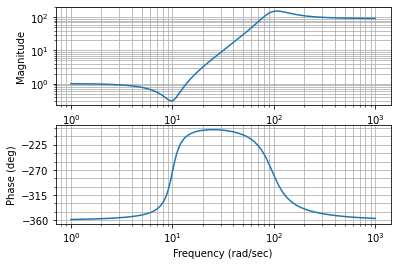

In [14]:
mag,phase,w = ctrl.bode(G)
mag = np.log10(mag)


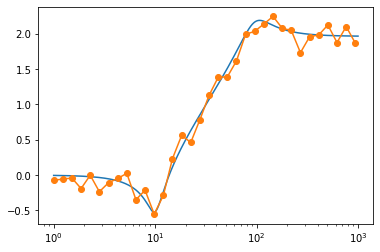

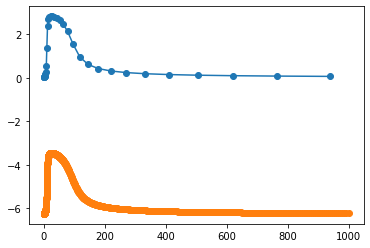

In [15]:
plt.semilogx(w,mag)

indx = np.arange(0,len(w),1)
indx = np.mod(indx,30)==0

ws = w[indx]
mags = mag[indx]
phases = phase[indx]

np.random.seed(1337)

mags += 0.1*np.random.randn(len(mags))

#phases = np.mod(phases,2*np.pi)

# Phase must start at within +/- 180 deg
if abs(phases[0]) >= np.pi:
    phases = np.mod(phases + np.pi,2*np.pi) - np.pi


plt.plot(ws, mags,'o-')
plt.figure()
plt.plot(ws, phases,'o-')
plt.plot(w, phase,'o-')

$$
G(s) = \dfrac{\omega_d^2}{\omega_n^2} \dfrac{s^2 + 2\delta_n \omega_n s + \omega_n^2}{s^2 + 2\delta_d \omega_d s + \omega_d^2}
$$

$$
|G(\omega)| = \dfrac{\omega_d^2}{\omega_n^2} \, \dfrac{\sqrt{(\omega_n^2 - \omega^2)^2 + (2\omega \omega_n \delta_n)^2}}{\sqrt{(\omega_d^2 - \omega^2)^2 + (2\omega \omega_d \delta_d)^2}} 
$$


$$
\log(|G(\omega)|) = 2\log(\omega_d) - 2\log(\omega_n) + \log\bigg( \sqrt{(\omega_n^2 - \omega^2)^2 + (2\omega \omega_n \delta_n)^2} \bigg) - \log \bigg( \sqrt{(\omega_d^2 - \omega^2)^2 + (2\omega \omega_d \delta_d)^2} \bigg)
$$




$$
\angle{G(\omega)} = \arctan \bigg(  (2\omega \omega_n \delta_n)^2 / (\omega_n^2 - \omega^2)^2 \bigg) - \arctan \bigg( (2\omega \omega_d \delta_d)^2 / (\omega_d^2 - \omega^2)^2 \bigg)
$$
$$
\angle{G(\omega)} = \texttt{atan2} \bigg(  (2\omega \omega_n \delta_n)^2 , (\omega_n^2 - \omega^2)^2 \bigg) - \texttt{atan2} \bigg( (2\omega \omega_d \delta_d)^2 , (\omega_d^2 - \omega^2)^2 \bigg)
$$

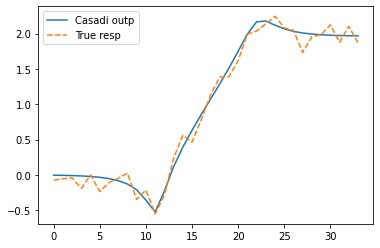

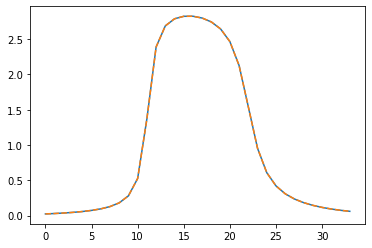

In [16]:

magis = []
phis = []
for i in range(len(ws)):

    wi = ws[i]
    # Mag
    t1Re = (wn**2 - wi**2)
    t1Im = (2*wn*wi*dn)

    t1 = t1Re**2 + t1Im**2

    t2Re = (wd**2 - wi**2)
    t2Im = (2*wd*wi*dd)

    t2 = t2Re**2 + t2Im**2

    #magi = casadi.log10(t1) - casadi.log10(t2) + 2*casadi.log10(k)
    magi = casadi.log10(casadi.sqrt(t1)) - casadi.log10(casadi.sqrt(t2)) + 2*(casadi.log10(wd)-casadi.log10(wn))

    #phi = casadi.arctan(t1Im/t1Re) - casadi.arctan(t2Im/t2Re) 
    phi = casadi.atan2(t1Im,t1Re) - casadi.atan2(t2Im,t2Re) 

    magis.append(magi)
    phis.append(phi)


#mag_true = 10**(mags)
#mag_true = np.log10(mag_true**2)

plt.plot(magis,label="Casadi outp")
plt.plot(mags,'--',label="True resp")
plt.legend()

plt.figure()
plt.plot(phis)
plt.plot(phases,'--')


In [17]:
opti = casadi.Opti()

def create_notch_vars(opti):

    wn = opti.variable()
    dn = opti.variable()

    opti.subject_to(wn>=1)
    opti.subject_to(wn <= 1e9)
    opti.set_initial(wn,100)

    opti.subject_to(dn>=0.05)
    opti.subject_to(dn <= 1.01)
    opti.set_initial(dn,0.5)

    wd = opti.variable()
    dd = opti.variable()

    opti.subject_to(wd>=1)
    opti.subject_to(wd <= 1e9)
    opti.set_initial(wd,100)

    opti.subject_to(dd>=0.05)
    opti.subject_to(dd <= 1.01)
    opti.set_initial(dd,0.5)

    return wn, dn, wd, dd 

#k = opti.variable()
#opti.subject_to(k>=0.1)
#opti.subject_to(k <= 1e9)
#opti.set_initial(k,100)

wn, dn, wd, dd  = create_notch_vars(opti)

J = 0

for i in range(len(ws)):

    wi = ws[i]
    # Complex terms
    t1Re = (wn**2 - wi**2)
    t1Im = (2*wn*wi*dn)

    t1 = t1Re**2 + t1Im**2

    t2Re = (wd**2 - wi**2)
    t2Im = (2*wd*wi*dd)

    t2 = t2Re**2 + t2Im**2

    # mag
    #magi = casadi.log10(t1) - casadi.log10(t2) + 2*casadi.log10(k)
    #magi = casadi.log10(t1) - casadi.log10(t2) + 4*(casadi.log10(wd)-casadi.log10(wn))
    magi = casadi.log10(casadi.sqrt(t1)) - casadi.log10(casadi.sqrt(t2)) + 2*(casadi.log10(wd)-casadi.log10(wn))

    #phi = casadi.arctan(t1Im/t1Re) - casadi.arctan(t2Im/t2Re) 
    phi = casadi.atan2(t1Im,t1Re) - casadi.atan2(t2Im,t2Re) 

    #mag_true = 10**mags[i]
    #mag_true = np.log10(mag_true**2)
    mag_true = mags[i]
    m_err = (mag_true - magi)**2
    ph_err = 180/np.pi*(phases[i] - phi)**2

    J += m_err + ph_err

opti.minimize(J);

opti.solver('ipopt');
sol = opti.solve();

print(f"wn: {sol.value(wn)} dn: {sol.value(dn)}")
print(f"wd: {sol.value(wd)} dd: {sol.value(dd)}")


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4171130e+03 0.00e+00 3.33e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

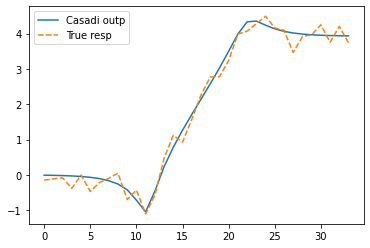

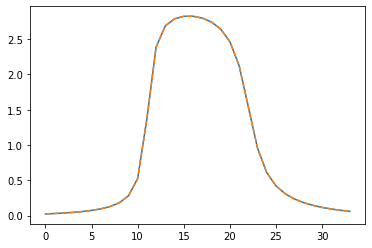

In [18]:

k = sol.value(k)
wn = sol.value(wn)
dn = sol.value(dn)
wd = sol.value(wd)
dd = sol.value(dd)


magis = []
phis = []
for i in range(len(ws)):

    wi = ws[i]
    # Mag
    t1Re = (wn**2 - wi**2)
    t1Im = (2*wn*wi*dn)

    t1 = t1Re**2 + t1Im**2

    t2Re = (wd**2 - wi**2)
    t2Im = (2*wd*wi*dd)

    t2 = t2Re**2 + t2Im**2

    magi = casadi.log10(t1) - casadi.log10(t2) + 2*casadi.log10(k)
    #magi = casadi.log10(t1) - casadi.log10(t2) + 4*(casadi.log10(wd)-casadi.log10(wn))

    #phi = casadi.arctan(t1Im/t1Re) - casadi.arctan(t2Im/t2Re) 
    phi = casadi.atan2(t1Im,t1Re) - casadi.atan2(t2Im,t2Re) 

    magis.append(magi)
    phis.append(phi)


mag_true = 10**(mags)
mag_true = np.log10(mag_true**2)

plt.plot(magis,label="Casadi outp")
plt.plot(mag_true,'--',label="True resp")
plt.legend()

plt.figure()
plt.plot(phis)
plt.plot(phases,'--')